This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

Defining our source

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.0478E+04 G

Coronal Particle Number Density:
 n_c = 3.4392E+10 cm-3

Coronal Temperature:
 T_c = 2.5282E+09 K

Width of the current sheet:
 delta_RX = 1.6649E+11 cm

Reconnection Power:
 wdot_B = 5.9912E+42 erg s-1


In [4]:
R_s

5920000000000.0

In [5]:
coronal_data.q

0.8200705800826866

In [6]:
## Energy range for protons and electrons [erg]

Ep = np.linspace(1e9, 1e20)*eV
Ee = np.linspace(1e9, 1e16)*eV

In [7]:
## Fluid density

rho = n_c * mp # [g cm-3]
rho

5.752425625949121e-14

In [8]:
## Normalizing

Ep_norm = Ep / (mp*c**2)
Ep_norm

array([1.06582075e+00, 2.17514439e+09, 4.35028877e+09, 6.52543315e+09,
       8.70057754e+09, 1.08757219e+10, 1.30508663e+10, 1.52260107e+10,
       1.74011551e+10, 1.95762995e+10, 2.17514438e+10, 2.39265882e+10,
       2.61017326e+10, 2.82768770e+10, 3.04520214e+10, 3.26271658e+10,
       3.48023102e+10, 3.69774545e+10, 3.91525989e+10, 4.13277433e+10,
       4.35028877e+10, 4.56780321e+10, 4.78531765e+10, 5.00283208e+10,
       5.22034652e+10, 5.43786096e+10, 5.65537540e+10, 5.87288984e+10,
       6.09040428e+10, 6.30791872e+10, 6.52543315e+10, 6.74294759e+10,
       6.96046203e+10, 7.17797647e+10, 7.39549091e+10, 7.61300535e+10,
       7.83051978e+10, 8.04803422e+10, 8.26554866e+10, 8.48306310e+10,
       8.70057754e+10, 8.91809198e+10, 9.13560642e+10, 9.35312085e+10,
       9.57063529e+10, 9.78814973e+10, 1.00056642e+11, 1.02231786e+11,
       1.04406930e+11, 1.06582075e+11])

In [9]:
## Alfvén Speed

v_a0 = B_c / np.sqrt(4 * np.pi * rho)

va = v_a0 * coronal_data.Gamma
va/c

0.29069046222286127

In [10]:
v_a0 / c

0.4110983941280743

In [11]:
va

8714609366.979158

In [12]:
c

29979000000.0

In [13]:
## Xu & Lazarian - 3rd Regime

v_in = 0.05 * va
beta_in = v_in / c
d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )

d_ur # [adim.]

0.01966916741367544

In [14]:
t_acc = 4*delta_RX / (c*d_ur)
t_acc # [s]

1129.4022114212746

In [15]:
# def time_acc_fermi(E):
#     '''Eq.(2.37) of Medina-Torrejon Thesis'''
#     alpha = 0.1
#     s = 1/alpha
#     E0 = 10**(4)
#     t0 = 700
#     ## hours
#     return s**(-1) * (E0/E)**(-1/s) * t0
#     # return (E0/E)**(-1/s) * t0


def time_acc_regime3(va, delta_RX):
    v_in = 0.05 * va
    beta_in = v_in / c
    d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )
    
    return 4 * delta_RX / (c * d_ur)


def time_acc_drift(E, B, va):
    '''Eq.(7) of Del Valle, de Gouveia Dal Pino & Kowal 2016 e de Gouveia Dal Pino & Kowal 2015'''
    v_rec = 0.05 * va
    
    return E / (qe*B*v_rec)

Hadrons

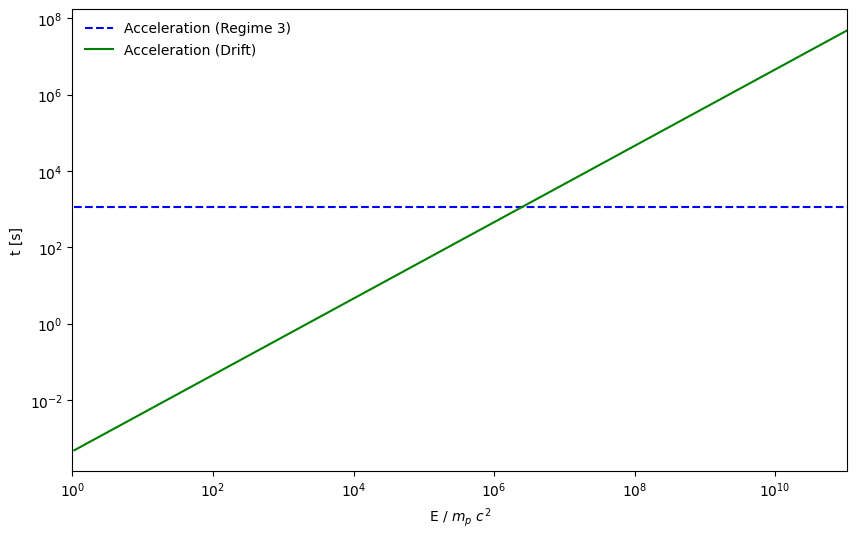

In [16]:
## erg

plt.figure(figsize=(10, 6))

plt.loglog(Ep_norm,[time_acc_regime3(va, delta_RX)]*len(Ep_norm),'--',label='Acceleration (Regime 3)',color='blue')
plt.loglog(Ep_norm,time_acc_drift(Ep_norm, B_c, va),label='Acceleration (Drift)',color='green')

plt.xlim((1e0,Ep_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [s]')
# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/acc_reconnection_drift.png',dpi=300)

plt.show()

Testing Tania's curve

In [17]:
from astropy.io import fits

# Function to inspect the FITS file structure
def inspect_fits(file_path):
    with fits.open(file_path) as hdul:
        hdul.info()  # Print the structure of the FITS file
        for i, hdu in enumerate(hdul):
            print(f"HDU {i}:")
            print(repr(hdu.header))
            if hdu.data is not None:
                print(f"Data shape: {hdu.data.shape}")

# Inspect the FITS file structure
inspect_fits('./partic_dedEdt_en.fits')

Filename: ./partic_dedEdt_en.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (3, 61)   float64   
HDU 0:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    3                                                  
NAXIS2  =                   61                                                  
EXTEND  =                    T                                                  
VAR     = 'Acceleration time'                                                   
Data shape: (61, 3)


In [18]:
from astropy.io import fits

# Function to read the .fits file and extract the columns
def readfits(file_path):
    with fits.open(file_path) as hdul:
        # Assuming the data is in the primary HDU
        data = hdul[0].data
    return data

# Read the .fits file
array = readfits('./partic_dedEdt_en.fits')  ## L / c

# Extract columns
tacc = array[:, 0]  # (Tempo de aceleração)
Eacc = array[:, 1]  # (Energy kinetica)
sdcc = array[:, 2]  # (desvio padrão, a observar)

In [19]:
# Print the extracted columns
# print("Tempo de aceleração:", tacc)
# print("Energy kinetica:", Eacc)
# print("Desvio padrão:", sdcc)

In [20]:
# tacc

In [21]:
# Eacc

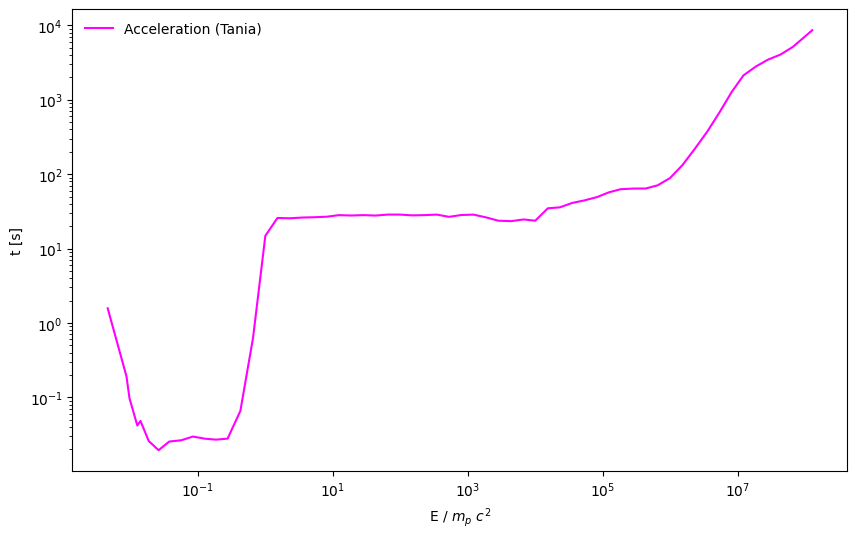

In [22]:
## Tanis

plt.figure(figsize=(10, 6))

plt.loglog(Eacc,tacc,label='Acceleration (Tania)',color='magenta')


# plt.xlim((1e0,E_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [s]')

# plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()

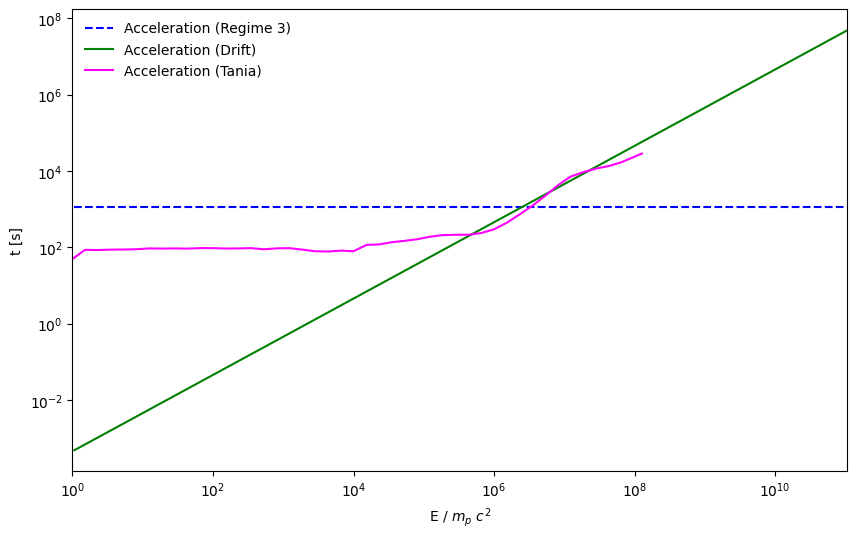

In [23]:
## erg

plt.figure(figsize=(10, 6))

plt.loglog(Ep_norm,[time_acc_regime3(va, delta_RX)]*len(Ep_norm),'--',label='Acceleration (Regime 3)',color='blue')
plt.loglog(Ep_norm,time_acc_drift(Ep_norm, B_c, va),label='Acceleration (Drift)',color='green')
plt.loglog(Eacc,tacc*(1e11/c),label='Acceleration (Tania)',color='magenta')
##### Tania's has a normalization factor

plt.xlim((1e0,Ep_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [s]')

# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
# plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()

## Maximum Accelerating Energy:

In [24]:
Z = 1.0 # proton case

E = (delta_RX * Z * B_c) / (33.36 * km )

print(f"Maximum Energy for proton (E) = {E:.2e} GeV")
print(f"iMaximum Energy for proton (E) = {E * 1e3:.2e} eV")
print(f"Maximum Energy for proton (E) = {E * GeV:.2e} erg")

Maximum Energy for proton (E) = 5.23e+08 GeV
iMaximum Energy for proton (E) = 5.23e+11 eV
Maximum Energy for proton (E) = 8.38e+05 erg
